In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import geopandas as gpd
import glob
from fos.dirs import basedir

plt.style.use('style.mplstyle')
outputsdir = '/global/cfs/cdirs/m4099/fate-of-snotel/wrfdata/Fig4_results/'

plasma_colors = ["#ffd700",
"#ffb14e",
"#fa8775",
"#ea5f94",
"#cd34b5",
"#9d02d7",
"#0000ff"]

colors_data = {'Data_1':'#ffd700', 'Data_2':'#fa8775', 'Data_3':'#ea5f94', 'Data_4':'#cd34b5','Data_5':'#0000ff'}
styles_model = {'linreg': '-', 'RF': '--', 'Unet': ':'}
labels_model = {'linreg': 'Linear Regression', 'RF': 'Random Forest', 'Unet': 'U-Net'}
colors_model = {'linreg':'black', 'RF':'gray', 'Unet': 'lightgray'}
colors_list = [plasma_colors[2], plasma_colors[4], plasma_colors[6]]

/global/homes/c/cowherd/.conda/envs/fos/lib/python3.11/site-packages/pyproj/__init__.py:90: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [12]:

# Function to plot fitted normal distribution
def plot_fitted_normal(data, ax, color, orientation = 'horizontal'):
    data = data[data>-2]
    mu, std = norm.fit(data)
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    if orientation == 'horizontal':
        ax.plot(x, p, color=color)
    if orientation == 'vertical':
        ax.plot(p,x, color = color)
        
# Function to create scatter plot with marginal histograms
def scatter_hist(x, y, ax, ax_histx, ax_histy, color, label, DIST = True):
    # Remove labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # Scatter plot
    ax.scatter(x, y, color = color, label = label, alpha = 0.4, marker = '+')

    # Fit and plot normal distribution on the scatter plot
    if DIST:
        plot_fitted_normal(x, ax_histx, color=color, orientation = 'horizontal')
        plot_fitted_normal(y,ax_histy, color=color, orientation = 'vertical')

        

In [2]:
## 1 show change in error by different model-year combinations, and then show the change in time
## 2 show what happens when you collapse the Data 3 and 4 rror proportions a la SAIL

In [2]:
## prep error data
outputsdir = '/global/cfs/cdirs/m4099/fate-of-snotel/wrfdata/umital/Fig4_results/'
err = xr.open_dataset(f'{outputsdir}/Err_allmodels_corrupteddata.nc').rename({'__xarray_dataarray_variable__':'value'})
exclude_values = ["Northern Oregon Coastal", "Rio Grande-Elephant Butte", "San Joaquin"]
for val in exclude_values:
    mask = err["basin"] != val
    err = err.where(mask, drop=True)
models = err.model.values
gcms = err.gcm.values
basins = err.basin.values
years = err.test_year.values
datas = err.pred_combo.values
metrics = err.metric.values

r2vals = err.sel(metric = 'r2')
rmsevals = err.sel(metric='rmse')

In [3]:
##just generate the numbers and save it and then plot them in the second oe
outdatas = {}
for i,data in enumerate(datas):
    outdatas[data] = {}
    for j,model in enumerate(models):
        outdatas[data][model] = []
        for n in range(len(basins)):
            name = basins[n]
            mydata = r2vals.sel(basin = name).sel(pred_combo = data).sel(model = model).mean(dim = 'gcm')['value']
            outdatas[data][model].append(mydata)

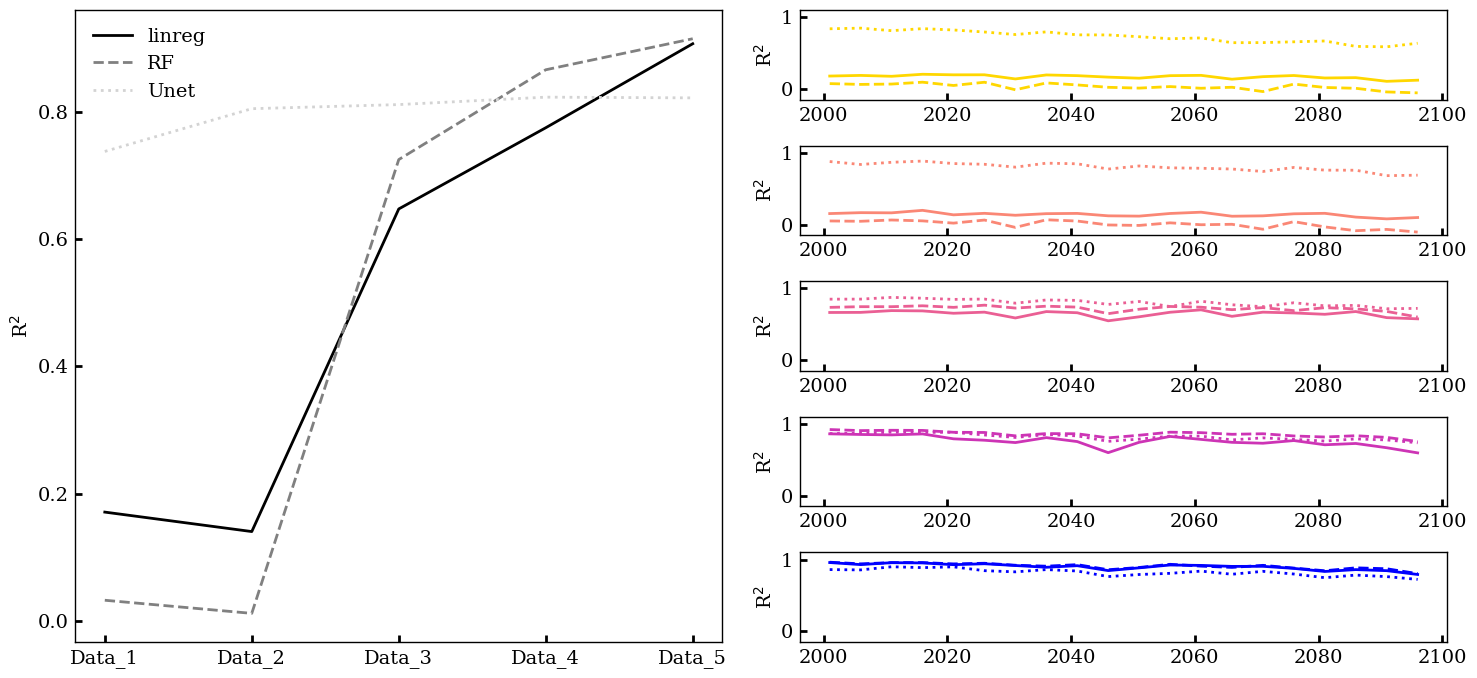

In [4]:
plt.rcParams['xtick.major.size'] = 5 
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.top'] = False  
plt.rcParams['ytick.right'] = False 
mosaic = """
    AB
    AC
    AD
    AE
    AF
    """
letters = ['B','C','D','E','F']
fig = plt.figure(figsize = (15,7), layout="tight")
ax_dict = fig.subplot_mosaic(mosaic)
ax = ax_dict['A']
for model in models:
    tmp = []
    for data in datas:
        mydata = outdatas[data][model][:]
        tmp.append(mydata)
    tmp = np.array(tmp)
    ax.plot(datas, np.nanmedian(tmp, axis = (1,2)), label = model, linestyle = styles_model[model], color = colors_model[model])

ax.legend()

ax.set_ylabel(r'R$^{2}$')
ax.legend()
for i, value in enumerate(datas):
    ax = ax_dict[letters[i]]
    for model in models:
        ax.plot(years, r2vals.sel(pred_combo = value).sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value,  color = colors_data[value], label = labels_model[model], linestyle = styles_model[model])
    ax.set_ylim((-0.15,1.1))
    ax.set_ylabel(r'R$^{2}$')
plt.show()

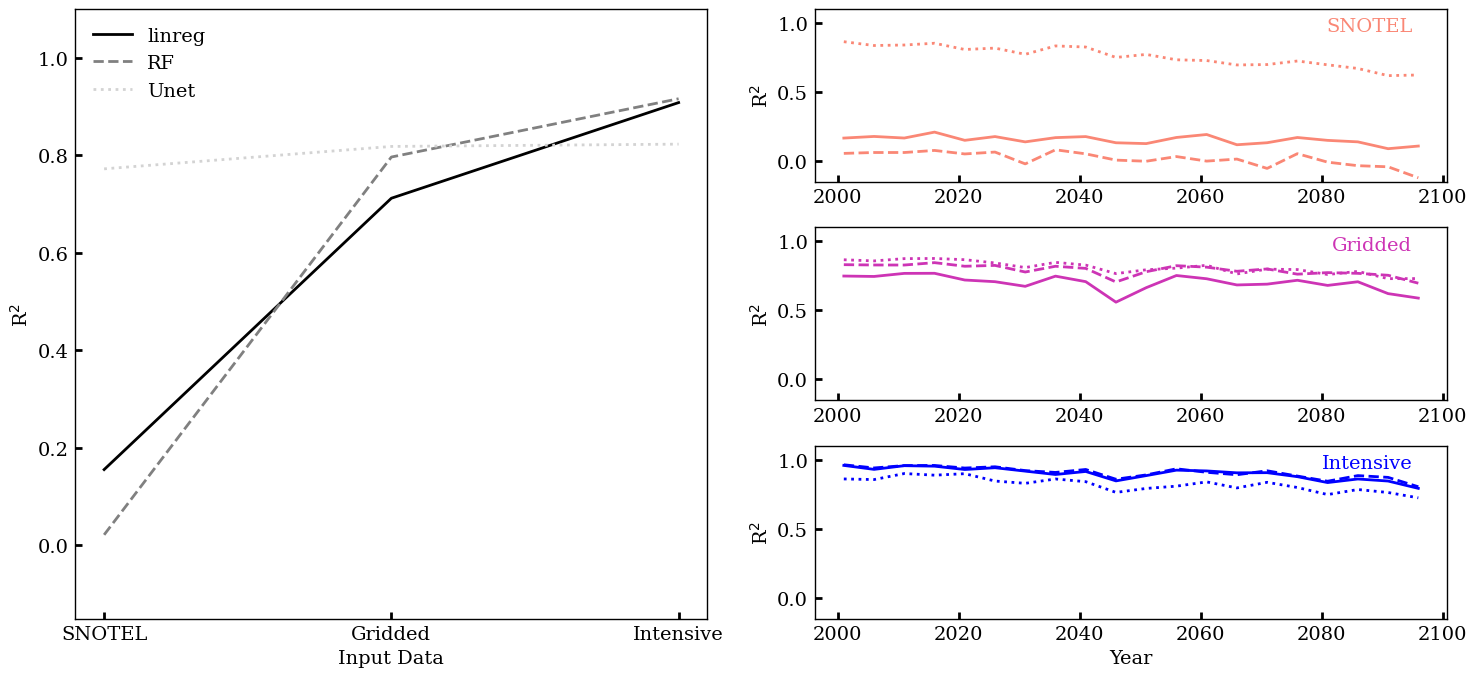

In [5]:
plt.rcParams['xtick.major.size'] = 5 
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.top'] = False  
plt.rcParams['ytick.right'] = False 
# datagrps = [[0],[1],[2],[3],[4]]
datagrps = [[0,1],[2,3],[4]]
ng = len(datagrps)
labels = ['SNOTEL', 'Gridded', 'Intensive']

mosaic = """
    AB
    AC
    AD
    """
letters = ['B','C','D']
fig = plt.figure(figsize = (15,7), layout="tight")
ax_dict = fig.subplot_mosaic(mosaic)
ax = ax_dict['A']
plot_arr = np.zeros((3,3))
for j, model in enumerate(models):
    tmp_model = []
    for i in range(ng):
        tmp = []
        idxs = datagrps[i]
        for idx in idxs:
            mydata = outdatas[datas[idx]][model][:]
            tmp.append(np.nanmedian(mydata))
        tmp_model.append(np.nanmean(tmp))
    #print(tmp_model)
    ax.plot(labels, tmp_model, label = model, linestyle = styles_model[model], color = colors_model[model])
    plot_arr[j] = tmp_model
    #ax.pcolormesh(plot_arr, cmap = 'plasma_r', vmin = 0, vmax = 1)
ax.legend()
ax.set_ylim((-0.15,1.1))
ax.set_xlabel('Input Data')
ax.set_ylabel(r'R$^{2}$')
ax.legend()
for i, idxs in enumerate(datagrps):
    value = [datas[idx] for idx in idxs] 
    ax = ax_dict[letters[i]]
    idxs = datagrps[i]
    for model in models:
        ax.plot(years, r2vals.sel(pred_combo = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value,  color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])
    ax.set_ylim((-0.15,1.1))
    ax.set_ylabel(r'R$^{2}$')
    ax.text(2095,0.94,labels[i], color = colors_data[value[-1]],ha = 'right')
ax.set_xlabel('Year')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


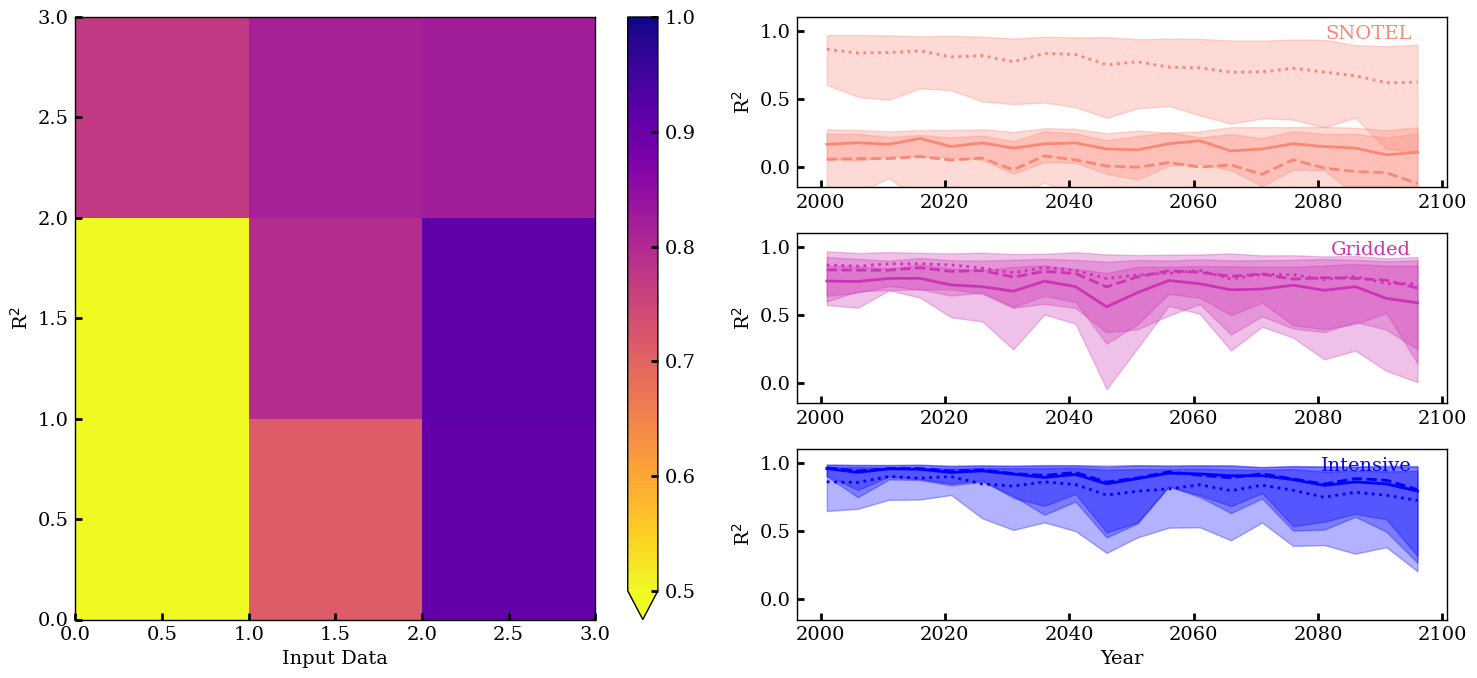

In [6]:
plt.rcParams['xtick.major.size'] = 5 
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.top'] = False  
plt.rcParams['ytick.right'] = False 
# datagrps = [[0],[1],[2],[3],[4]]
datagrps = [[0,1],[2,3],[4]]
ng = len(datagrps)
labels = ['SNOTEL', 'Gridded', 'Intensive']

mosaic = """
    AB
    AC
    AD
    """
letters = ['B','C','D']
fig = plt.figure(figsize = (15,7), layout="tight")
ax_dict = fig.subplot_mosaic(mosaic)
ax = ax_dict['A']
plot_arr = np.zeros((3,3))
for j, model in enumerate(models):
    tmp_model = []
    for i in range(ng):
        tmp = []
        idxs = datagrps[i]
        for idx in idxs:
            mydata = outdatas[datas[idx]][model][:]
            tmp.append(np.nanmedian(mydata))
        tmp_model.append(np.nanmean(tmp))
    #print(tmp_model)
    #ax.plot(labels, tmp_model, label = model, linestyle = styles_model[model], color = colors_model[model])
    plot_arr[j] = tmp_model
cbar =  ax.pcolormesh(plot_arr, cmap = 'plasma_r' , vmin = 0.5, vmax = 1)
#ax.legend()
plt.colorbar(cbar, extend = 'min')
#ax.set_ylim((-0.15,1.1))
ax.set_xlabel('Input Data')
ax.set_ylabel(r'R$^{2}$')
ax.legend()
for i, idxs in enumerate(datagrps):
    value = [datas[idx] for idx in idxs] 
    ax = ax_dict[letters[i]]
    idxs = datagrps[i]
    for model in models[0:3]:
        mints =  r2vals.sel(pred_combo = value).mean(dim = 'pred_combo').sel(model = model).min(dim = 'gcm').median(dim = 'basin').value
        maxts =  r2vals.sel(pred_combo = value).mean(dim = 'pred_combo').sel(model = model).max(dim = 'gcm').median(dim = 'basin').value
        #ax.plot(years,,  color = colors_data[value[-1]], alpha = 0.3, label = labels_model[model], linestyle = styles_model[model])
        ax.fill_between(years, mints, maxts, alpha = 0.3, color = colors_data[value[-1]])
        ax.plot(years, r2vals.sel(pred_combo = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value,  color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])
        #ax.plot(years, r2vals.sel(pred_combo = value).mean(dim = 'pred_combo').sel(model = model).min(dim = 'gcm').median(dim = 'basin').value,  color = colors_data[value[-1]], alpha= 0.3 , label = labels_model[model], linestyle = styles_model[model])
    ax.set_ylim((-0.15,1.1))
    ax.set_ylabel(r'R$^{2}$')
    ax.text(2095,0.94,labels[i], color = colors_data[value[-1]],ha = 'right')
ax.set_xlabel('Year')
plt.show()

/global/homes/c/cowherd/.conda/envs/fos/lib/python3.11/site-packages/matplotlib_inline/backend_inline.py:27: UserWarning: The Figure parameters 'layout' and 'constrained_layout' cannot be used together. Please use 'layout' only.
  return new_figure_manager_given_figure(num, FigureClass(*args, **kwargs))


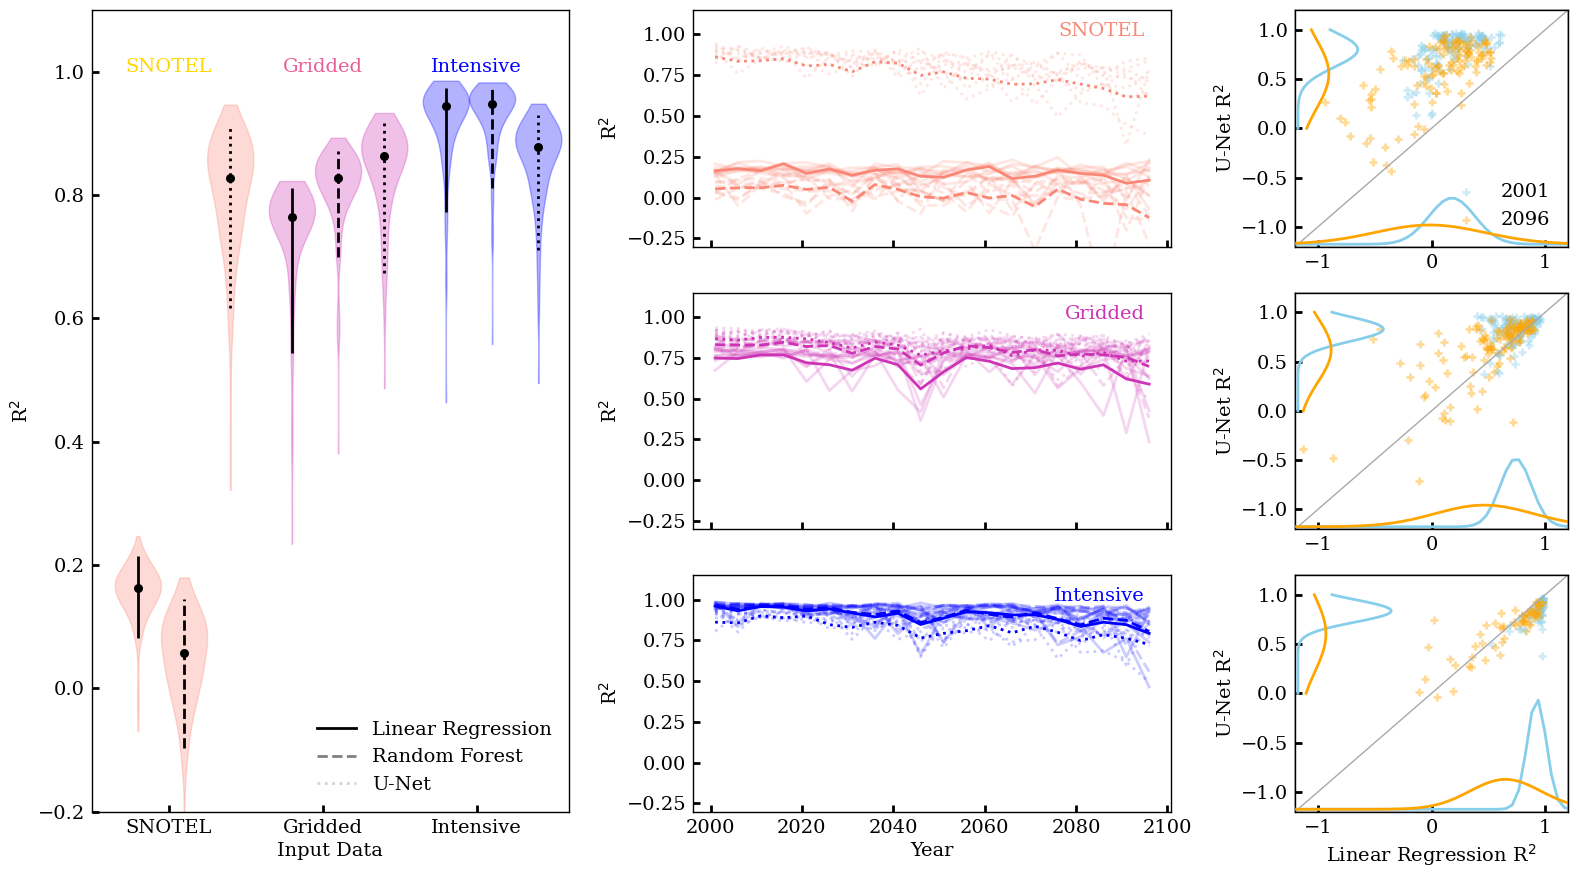

In [30]:
plt.rcParams['xtick.major.size'] = 5 
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.top'] = False  
plt.rcParams['ytick.right'] = False 
# datagrps = [[0],[1],[2],[3],[4]]
datagrps = [[0,1],[2,3],[4]]
datagroups = [['Data_1','Data_2'], ['Data_3', 'Data_4'], ['Data_5']]
labels = ['SNOTEL', 'Gridded', 'Intensive']

def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

mosaic = """
    ABE
    ACF
    ADG
    """
letters = ['B','C','D']

fig = plt.figure(figsize=(16, 9), layout="tight", constrained_layout=True) #, gridspec_kw={"width_ratios": [1, 1, 1]})
#gs = fig.add_gridspec(3, 3, width_ratios=[5, 5, 3])


ax_dict = fig.subplot_mosaic(mosaic,
    height_ratios=[1, 1, 1],
    width_ratios=[7,7,4],)
ax = ax_dict['A']
allpcs = []
for c,model in enumerate(models):
    mypositions = [num + (c+1) *0.3 for num in range(3)]
    tmp_model = []
    for pred_combos in datagroups:
        data2plot = r2vals.sel(pred_combo = pred_combos).mean(dim = 'pred_combo').sel(model = model).median(dim = 'basin').value.values
        tmp_model.append(data2plot.flatten())
    prep_boxplots = tmp_model
    prep_boxplots = [arr for arr in prep_boxplots]
    vplot = ax.violinplot(prep_boxplots, positions = mypositions, 
                          showmeans = False, showextrema = False,
                         widths = 0.3)# , color = colors_models[model]) #, label = model)# linestyle = styles_model[model], color = colors_model[model])

    allpcs.append(vplot['bodies'])
#        pc.set_facecolor(colors_list)
#        pc.set_edgecolor(colors_list)
    
    quartile1, medians, quartile3 = np.percentile(prep_boxplots, [5,50, 95], axis=1)
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(prep_boxplots, quartile1, quartile3)])
    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, -1]

    ax.scatter(mypositions, medians, marker='o', color='k', s=30, zorder=3)
    ax.vlines(mypositions, quartile1, quartile3, color='k', linestyle = styles_model[model], lw=2)
    #ax.vlines(mypositions, whiskers_min, whiskers_max, color=colors_model[model])# , linestyle = styles_model[model], lw=1)
ticks, labels = [0.5,1.5,2.5], ['SNOTEL', 'Gridded', 'Intensive']
ax.set_xticks(ticks, labels)
for i, tick in enumerate(ticks):
    ax.text(tick, 1, labels[i], horizontalalignment ='center', color = colors_data[datas[i*2]])


for i, color in enumerate(colors_list):
    for pc in allpcs:
        pc[i].set_facecolor(color)
        pc[i].set_edgecolor(color)
        
# ax.set_yscale('log')
for model in models:
    ax.plot([-10,-10],[-10,-10], color = colors_model[model], label = labels_model[model], linestyle = styles_model[model])
ax.set_ylim((-0.2,1.1))
ax.set_xlim((-0.0,3.1))

ax.set_xlabel('Input Data')
ax.set_ylabel(r'R$^{2}$')
ax.legend( loc = 'lower right')
for i, idxs in enumerate(datagrps):
    value = [datas[idx] for idx in idxs] 
    ax = ax_dict[letters[i]]
    idxs = datagrps[i]
    for model in models:
        for gcm in gcms:
            ax.plot(years, r2vals.sel(pred_combo = value).mean(dim = 'pred_combo').sel(model = model).sel(gcm = gcm).median(dim = 'basin').value, alpha = 0.2, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])
        ax.plot(years, r2vals.sel(pred_combo = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])

    ax.set_ylim((-0.3,1.15))
    ax.set_ylabel(r'R$^{2}$')
    ax.text(2095,0.99,labels[i], color = colors_data[value[-1]],ha = 'right')
    if i < 2:
        ax.set_xticklabels([])
ax.set_xlabel('Year')

## horror show year vs "good year"
year_1 = 2001
year_2 = 2096

# Function to plot fitted normal distribution
def plot_fitted_normal(data, ax, color, orientation = 'horizontal'):
    data = data[data>-2]
    mu, std = norm.fit(data)
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    if orientation == 'horizontal':
        ax.plot(x, p, color=color)
    if orientation == 'vertical':
        ax.plot(p,x, color = color)
def set_border(ax, width = 1):
     
    #not sure how they ended up wide?
    ax.spines['top'].set_linewidth(width)
    ax.spines['right'].set_linewidth(width)
    ax.spines['bottom'].set_linewidth(width)
    ax.spines['left'].set_linewidth(width)
    
    return

letters = ['E','F','G']
for i, data in enumerate(datagroups):
    unet1 = r2vals.sel(test_year = year_1).mean(dim = 'gcm').sel(pred_combo = data).sel(model = 'Unet').value.data.flatten()
    linreg1 = r2vals.sel(test_year = year_1).mean(dim = 'gcm').sel(pred_combo = data).sel(model = 'linreg').value.data.flatten()
    rf1 = r2vals.sel(test_year = year_1).mean(dim = 'gcm').sel(pred_combo = data).sel(model = 'RF').value.data.flatten()
    unet2 = r2vals.sel(test_year = year_2).mean(dim = 'gcm').sel(pred_combo = data).sel(model = 'Unet').value.data.flatten()
    linreg2 = r2vals.sel(test_year = year_2).mean(dim = 'gcm').sel(pred_combo = data).sel(model = 'linreg').value.data.flatten()
    rf2 = r2vals.sel(test_year = year_2).mean(dim = 'gcm').sel(pred_combo = data).sel(model = 'RF').value.data.flatten()
    ax = ax_dict[letters[i]]
    ax.plot([-2,2],[-2,2], linewidth = 1, color = 'darkgray')
    DIST = False
    scatter_hist(linreg1, unet1, ax, ax_histx, ax_histy, color = 'skyblue', label = '2001', DIST = DIST)
    scatter_hist(linreg2, unet2, ax, ax_histx, ax_histy, color = 'orange', label = '2096',DIST = DIST)
    if i ==0: ax.legend()
    for j,x in enumerate([[linreg1, linreg2], [unet1, unet2]]):
        if j ==0:
            color = 'skyblue'
            for xm in x:
                axm = ax.twinx()
                plot_fitted_normal(xm, axm, color=color, orientation = 'horizontal')
                axm.set_xlim((-1.2,1.2))
                axm.set_ylim((-0.1,10))
                axm.set_yticks([])
                color = 'orange'
                set_border(axm, 0.1)

        else:
            color = 'skyblue'
            for xm in x:
                axm = ax.twiny()
                plot_fitted_normal(xm, axm, color = color, orientation = 'vertical')
                axm.set_ylim((-1.2,1.2))
                axm.set_xlim((-0.1,10))
                axm.set_xticks([])
                color = 'orange'
                set_border(axm,.1)

    ax.set_xlim((-1.2,1.2))
    ax.set_ylim((-1.2,1.2))
    ax.set_ylabel(r'U-Net R$^{2}$')
    
   

ax.set_xlabel(r'Linear Regression R$^{2}$')

plt.show()


In [14]:
## try 2096 as a horror show year

array([2001, 2006, 2011, 2016, 2021, 2026, 2031, 2036, 2041, 2046, 2051,
       2056, 2061, 2066, 2071, 2076, 2081, 2086, 2091, 2096])

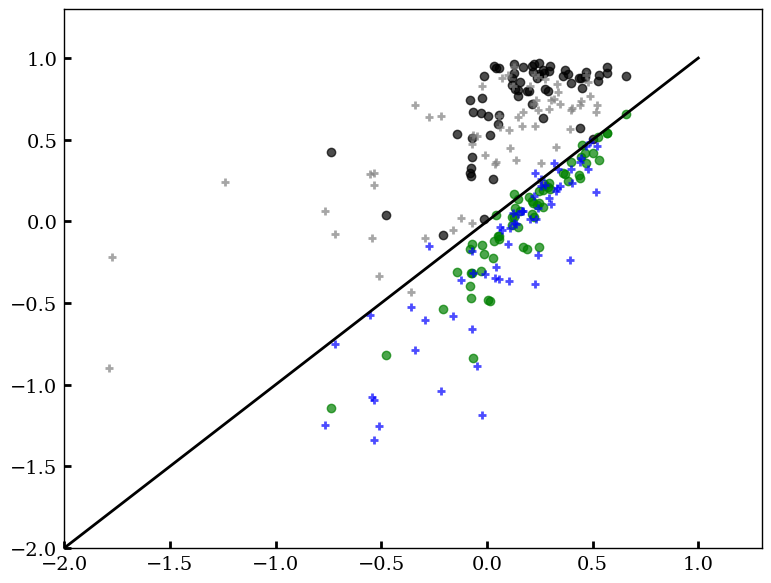

In [33]:
unet = r2vals.sel(test_year = 2006).mean(dim = 'gcm').sel(pred_combo = 'Data_1').sel(model = 'Unet').value #  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])
linreg = r2vals.sel(test_year = 2006).mean(dim = 'gcm').sel(pred_combo = 'Data_1').sel(model = 'linreg').value#  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])
rf = r2vals.sel(test_year = 2006).mean(dim = 'gcm').sel(pred_combo = 'Data_1').sel(model = 'RF').value#  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])

unet1 = r2vals.sel(test_year = 2096).mean(dim = 'gcm').sel(pred_combo = 'Data_1').sel(model = 'Unet').value #  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])
linreg1 = r2vals.sel(test_year = 2096).mean(dim = 'gcm').sel(pred_combo = 'Data_1').sel(model = 'linreg').value#  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])
rf1 = r2vals.sel(test_year = 2096).mean(dim = 'gcm').sel(pred_combo = 'Data_1').sel(model = 'RF').value#  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])


fig,ax = plt.subplots()
ax.scatter(linreg, unet, alpha = 0.7, marker = 'o')
ax.scatter(linreg, rf, alpha = 0.7, marker = 'o', color = 'green')

ax.scatter(linreg1, unet1, alpha = 0.7, marker = '+', color = 'gray')
ax.scatter(linreg1, rf1, alpha = 0.7, marker = '+', color = 'blue')

ax.plot([-2,1],[-2,1], 'k-')
ax.set_xlim((-2,1.3))
ax.set_ylim((-2,1.3))
plt.show()

NameError: name 'linreg' is not defined

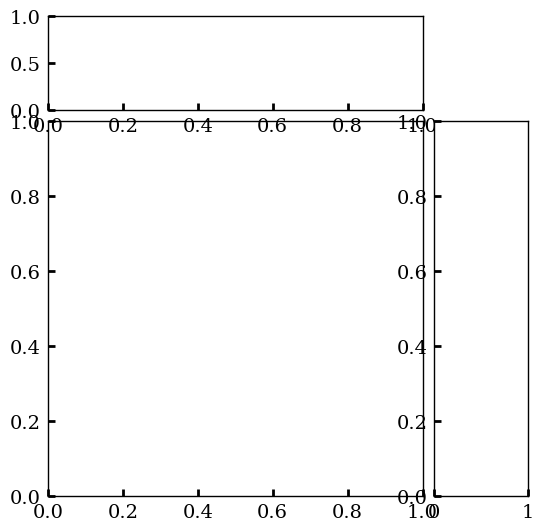

In [8]:

fig = plt.figure(figsize=(6, 6))

gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(linreg, unet, ax, ax_histx, ax_histy)
#scatter_hist(linreg, rf, ax, ax_histx, ax_histy)
scatter_hist(linreg1, unet1, ax, ax_histx, ax_histy)
#scatter_hist(linreg1, rf1, ax, ax_histx, ax_histy)
ax.plot([-2,1.3],[-2,1.3])
ax.set_xlim((-2,1.3))
ax.set_ylim((-2,1.3))


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 49., 15.]),
 array([-7.16514215, -6.29269188, -5.42024161, -4.54779135, -3.67534108,
        -2.80289081, -1.93044054, -1.05799028, -0.18554001,  0.68691026,
         1.55936052]),
 <BarContainer object of 10 artists>)

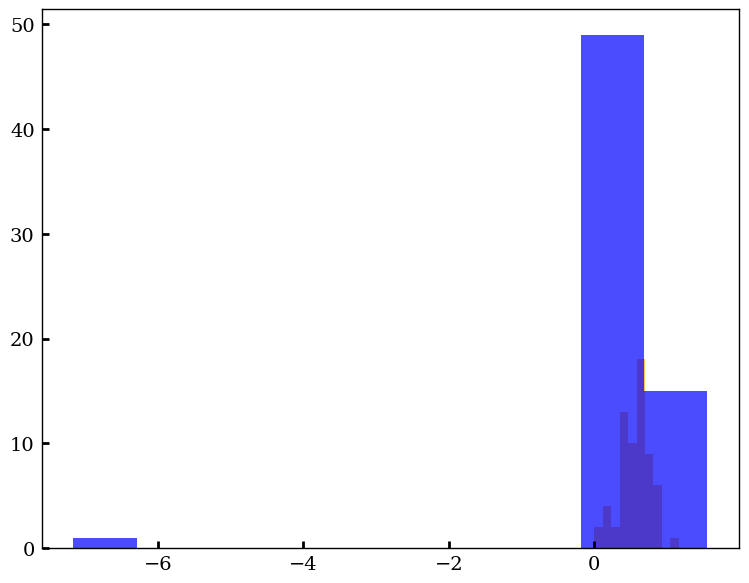

In [62]:
plt.hist(unet - linreg, alpha = 0.7, color = 'orange')
#plt.hist(rf - linreg, alpha = 0.3, color = 'red')
tmp = unet1 - linreg1
plt.hist(tmp, alpha = 0.7, color = 'blue')
#plt.hist(rf1 - linreg1, alpha = 0.3, color = 'purple')

(-0.3, 1.0)

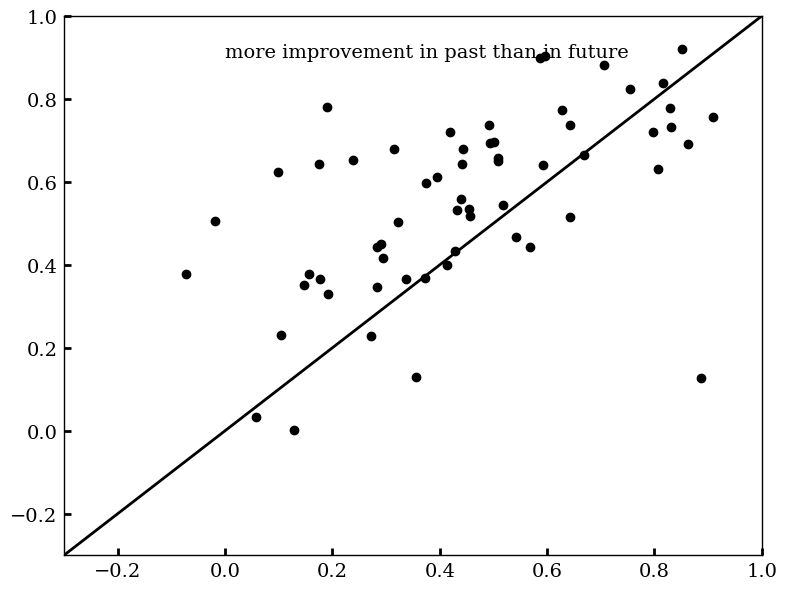

In [68]:
plt.scatter(tmp, unet-linreg)
plt.plot([-4,1], [-4,1])
plt.text(0, .9, 'more improvement in past than in future')
plt.xlim((-0.3,1))
plt.ylim((-0.3,1))

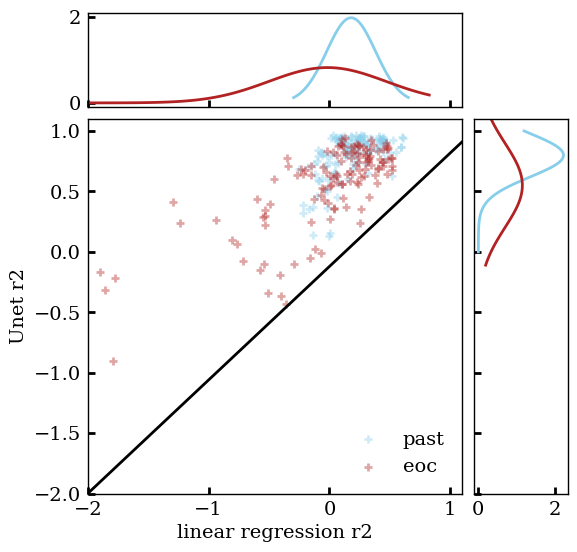

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

unet = r2vals.sel(test_year = 2001).mean(dim = 'gcm').sel(pred_combo = ['Data_1', 'Data_2']).sel(model = 'Unet').value.data.flatten() #  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])
linreg = r2vals.sel(test_year = 2001).mean(dim = 'gcm').sel(pred_combo = ['Data_1', 'Data_2']).sel(model = 'linreg').value.data.flatten() #  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])
rf = r2vals.sel(test_year = 2001).mean(dim = 'gcm').sel(pred_combo = ['Data_1', 'Data_2']).sel(model = 'RF').value.data.flatten() #  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])

unet1 = r2vals.sel(test_year = 2096).mean(dim = 'gcm').sel(pred_combo = ['Data_1', 'Data_2']).sel(model = 'Unet').value.data.flatten() #  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])
linreg1 = r2vals.sel(test_year = 2096).mean(dim = 'gcm').sel(pred_combo = ['Data_1', 'Data_2']).sel(model = 'linreg').value.data.flatten()#  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])
rf1 = r2vals.sel(test_year = 2096).mean(dim = 'gcm').sel(pred_combo = ['Data_1', 'Data_2']).sel(model = 'RF').value.data.flatten()#  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])


# Assuming you have the data for the scatter plots in the variables linreg, unet, rf, linreg1, unet1, rf1

# Function to plot fitted normal distribution
def plot_fitted_normal(data, ax, color, orientation = 'horizontal'):
    data = data[data>-2]
    mu, std = norm.fit(data)
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    if orientation == 'horizontal':
        ax.plot(x, p, color=color)
    if orientation == 'vertical':
        ax.plot(p,x, color = color)
        
# Function to create scatter plot with marginal histograms
def scatter_hist(x, y, ax, ax_histx, ax_histy, color, label, DIST = True):
    # Remove labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # Scatter plot
    ax.scatter(x, y, color = color, label = label, alpha = 0.4, marker = '+')

    # Fit and plot normal distribution on the scatter plot
    if DIST:
        plot_fitted_normal(x, ax_histx, color=color, orientation = 'horizontal')
        plot_fitted_normal(y,ax_histy, color=color, orientation = 'vertical')

        
        
fig = plt.figure(figsize=(6, 6))

gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# Draw the scatter plot and fitted normal distributions
scatter_hist(linreg, unet, ax, ax_histx, ax_histy, color = 'skyblue', label = 'past')
#scatter_hist(linreg, rf, ax, ax_histx, ax_histy)
scatter_hist(linreg1, unet1, ax, ax_histx, ax_histy, color = 'firebrick', label = 'eoc')
#scatter_hist(linreg1, rf1, ax, ax_histx, ax_histy)
ax.plot([-2,1.3],[-2,1.1])
ax.set_xlim((-2, 1.1))
ax.set_ylim((-2, 1.1))
ax.set_xlabel('linear regression r2')
ax.set_ylabel('Unet r2')
ax.legend(loc = 'lower right')
plt.show()


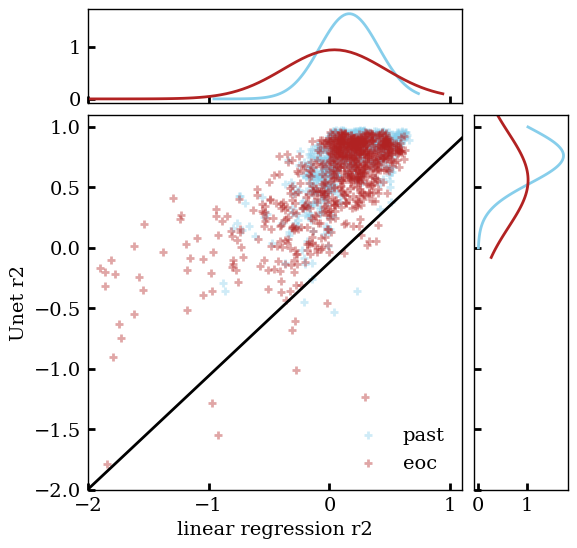

In [107]:
unet = r2vals.sel(test_year = slice(1990, 2030)).mean(dim = 'gcm').sel(pred_combo = ['Data_1', 'Data_2']).sel(model = 'Unet').value.data.flatten() #  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])
linreg = r2vals.sel(test_year = slice(1990,2030)).mean(dim = 'gcm').sel(pred_combo = ['Data_1', 'Data_2']).sel(model = 'linreg').value.data.flatten() #  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])
rf = r2vals.sel(test_year  = slice(1990,2030)).mean(dim = 'gcm').sel(pred_combo = ['Data_1', 'Data_2']).sel(model = 'RF').value.data.flatten() #  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])

unet1 = r2vals.sel(test_year = slice(2070,2097)).mean(dim = 'gcm').sel(pred_combo = ['Data_1', 'Data_2']).sel(model = 'Unet').value.data.flatten() #  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])
linreg1 = r2vals.sel(test_year = slice(2070,2097)).mean(dim = 'gcm').sel(pred_combo = ['Data_1', 'Data_2']).sel(model = 'linreg').value.data.flatten()#  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])
rf1 = r2vals.sel(test_year = slice(2070,2097)).mean(dim = 'gcm').sel(pred_combo = ['Data_1', 'Data_2']).sel(model = 'RF').value.data.flatten()#  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])

fig = plt.figure(figsize=(6, 6))

gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# Draw the scatter plot and fitted normal distributions
scatter_hist(linreg, unet, ax, ax_histx, ax_histy, color = 'skyblue', label = 'past')
#scatter_hist(linreg, rf, ax, ax_histx, ax_histy)
scatter_hist(linreg1, unet1, ax, ax_histx, ax_histy, color = 'firebrick', label = 'eoc')
#scatter_hist(linreg1, rf1, ax, ax_histx, ax_histy)
ax.plot([-2,1.3],[-2,1.1])
ax.set_xlim((-2, 1.1))
ax.set_ylim((-2, 1.1))
ax.set_xlabel('linear regression r2')
ax.set_ylabel('Unet r2')
ax.legend(loc = 'lower right')
plt.show()


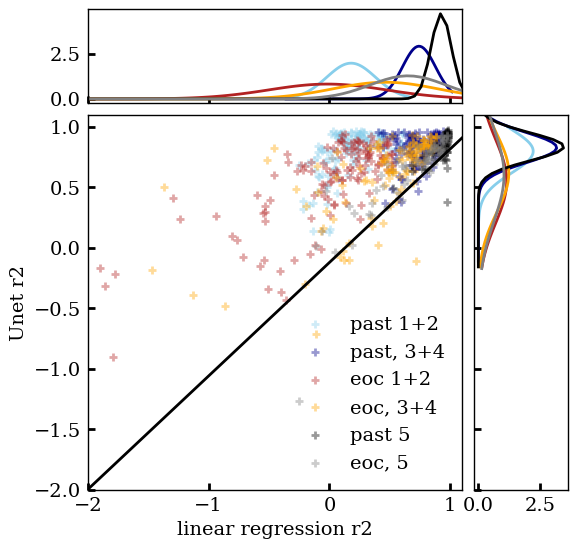

In [115]:
unet = r2vals.sel(test_year = 2001).mean(dim = 'gcm').sel(pred_combo = ['Data_1', 'Data_2']).sel(model = 'Unet').value.data.flatten() #  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])
linreg = r2vals.sel(test_year = 2001).mean(dim = 'gcm').sel(pred_combo = ['Data_1', 'Data_2']).sel(model = 'linreg').value.data.flatten() #  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])
rf = r2vals.sel(test_year = 2001).mean(dim = 'gcm').sel(pred_combo = ['Data_1', 'Data_2']).sel(model = 'RF').value.data.flatten() #  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])

unet1 = r2vals.sel(test_year = 2096).mean(dim = 'gcm').sel(pred_combo = ['Data_1', 'Data_2']).sel(model = 'Unet').value.data.flatten() #  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])
linreg1 = r2vals.sel(test_year = 2096).mean(dim = 'gcm').sel(pred_combo = ['Data_1', 'Data_2']).sel(model = 'linreg').value.data.flatten()#  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])
rf1 = r2vals.sel(test_year = 2096).mean(dim = 'gcm').sel(pred_combo = ['Data_1', 'Data_2']).sel(model = 'RF').value.data.flatten()#  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])

unet2 = r2vals.sel(test_year = 2001).mean(dim = 'gcm').sel(pred_combo = ['Data_3', 'Data_4']).sel(model = 'Unet').value.data.flatten() #  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])
linreg2 = r2vals.sel(test_year = 2001 ).mean(dim = 'gcm').sel(pred_combo = ['Data_3', 'Data_4']).sel(model = 'linreg').value.data.flatten() #  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])
rf2 = r2vals.sel(test_year  = 2001).mean(dim = 'gcm').sel(pred_combo = ['Data_3', 'Data_4']).sel(model = 'RF').value.data.flatten() #  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])

unet3 = r2vals.sel(test_year = 2096).mean(dim = 'gcm').sel(pred_combo = ['Data_3', 'Data_4']).sel(model = 'Unet').value.data.flatten() #  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])
linreg3 = r2vals.sel(test_year = 2096).mean(dim = 'gcm').sel(pred_combo = ['Data_3', 'Data_4']).sel(model = 'linreg').value.data.flatten()#  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])
rf3 = r2vals.sel(test_year =2096).mean(dim = 'gcm').sel(pred_combo = ['Data_3', 'Data_4']).sel(model = 'RF').value.data.flatten()#  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])

unet4 = r2vals.sel(test_year = 2001).mean(dim = 'gcm').sel(pred_combo = ['Data_5']).sel(model = 'Unet').value.data.flatten() #  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])
linreg4 = r2vals.sel(test_year = 2001 ).mean(dim = 'gcm').sel(pred_combo = ['Data_5']).sel(model = 'linreg').value.data.flatten() #  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])
rf4 = r2vals.sel(test_year  = 2001).mean(dim = 'gcm').sel(pred_combo = ['Data_5']).sel(model = 'RF').value.data.flatten() #  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])

unet5 = r2vals.sel(test_year = 2096).mean(dim = 'gcm').sel(pred_combo = ['Data_5']).sel(model = 'Unet').value.data.flatten() #  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])
linreg5 = r2vals.sel(test_year = 2096).mean(dim = 'gcm').sel(pred_combo = ['Data_5']).sel(model = 'linreg').value.data.flatten()#  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])
rf5 = r2vals.sel(test_year =2096).mean(dim = 'gcm').sel(pred_combo = ['Data_5']).sel(model = 'RF').value.data.flatten()#  = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])


fig = plt.figure(figsize=(6, 6))

gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# Draw the scatter plot and fitted normal distributions
scatter_hist(linreg, unet, ax, ax_histx, ax_histy, color = 'skyblue', label = 'past 1+2')
scatter_hist(linreg2, unet2, ax, ax_histx, ax_histy, color = 'darkblue', label = 'past, 3+4')
scatter_hist(linreg1, unet1, ax, ax_histx, ax_histy, color = 'firebrick', label = 'eoc 1+2')
scatter_hist(linreg3, unet3, ax, ax_histx, ax_histy, color = 'orange', label = 'eoc, 3+4')
scatter_hist(linreg4, unet4, ax, ax_histx, ax_histy, color = 'black', label = 'past 5')
scatter_hist(linreg5, unet5, ax, ax_histx, ax_histy, color = 'gray', label = 'eoc, 5')

ax.plot([-2,1.3],[-2,1.1])
ax.set_xlim((-2, 1.1))
ax.set_ylim((-2, 1.1))
ax.set_xlabel('linear regression r2')
ax.set_ylabel('Unet r2')
ax.legend(loc = 'lower right')
plt.show()


In [419]:
pc

[array([ 0.88027494,  0.37651123,  0.78015873,  0.82025719,  0.85310067,
         0.86951565,  0.71569592,  0.76053246,  0.89805251, -0.0547507 ,
         0.45602485,  0.86641513,  0.90683587,  0.59217489,  0.29691966,
         0.27175855,  0.62881173,  0.27803282,  0.83743593,  0.78633466,
         0.70425965,  0.84935954,  0.78722009,  0.64130853,  0.74650576,
         0.781981  ,  0.41608463,  0.88285855,  0.88482986,  0.53554543,
         0.89726506,  0.85542138,  0.81730672,  0.69231203, -0.00318368,
         0.92150738,  0.68304734,  0.91201312,  0.87377995,  0.86574787,
         0.8041676 ,  0.14405926,  0.17125042,  0.63892064,  0.79954903,
         0.94441224,  0.90379175, -0.3928098 ,  0.06024986,  0.3020004 ,
         0.70583635,  0.11687897,  0.85932864,  0.90178741,  0.28596458,
         0.72881666,  0.65514097,  0.86964491,  0.92612637,  0.88250333,
         0.57625425,  0.4979437 ,  0.34479977,  0.60541598,  0.52913333]),
 array([ 0.89212402,  0.57660422,  0.81958953,  0

array([[0.4979437 , 0.52913333],
       [0.63837681, 0.67029892],
       [0.66896151, 0.69207937]])

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f7365ccdad0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f73654fbe10>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f73650f1bd0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f73655ad310>}

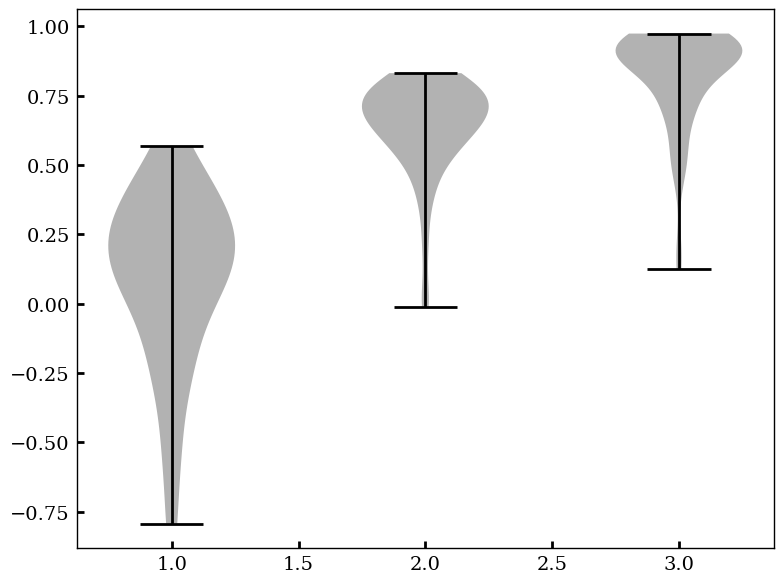

In [354]:
plt.violinplot(prep_boxplots)

In [351]:
prep_boxplots

[array([ 0.06270468, -0.0863024 ,  0.11810061,  0.18243347,  0.2386004 ,
         0.19943446,  0.22106375,  0.38974169,  0.15777385, -0.22711551,
         0.2805473 ,  0.23161307,  0.20518507, -0.32491425, -0.32421211,
        -0.50523794,  0.37982164, -0.06934411,  0.4099565 ,  0.07620159,
         0.26915864,  0.54646   ,  0.01158226,  0.07944546,  0.31989678,
         0.28210462, -0.20217983,  0.56862811,  0.44531845, -0.07363042,
         0.24103364,  0.09475172,  0.53292278,  0.29725707, -0.79235342,
         0.00653215,  0.2075699 ,  0.33619627,  0.46363369,  0.10179833,
         0.10053604, -0.15854899, -0.79000011,  0.05163835,  0.31149605,
         0.10579684,  0.2566179 , -0.42574877, -0.55331701, -0.10280308,
         0.48948624, -0.59261699,  0.04706119,  0.36900075, -0.24754724,
         0.12622921,  0.34632006,  0.44619028,  0.3059232 ,  0.06987771,
        -0.25315177, -0.1071492 ,  0.18653787,  0.18673586,  0.43129214]),
 array([ 0.728989  ,  0.64683682,  0.79770751,  0

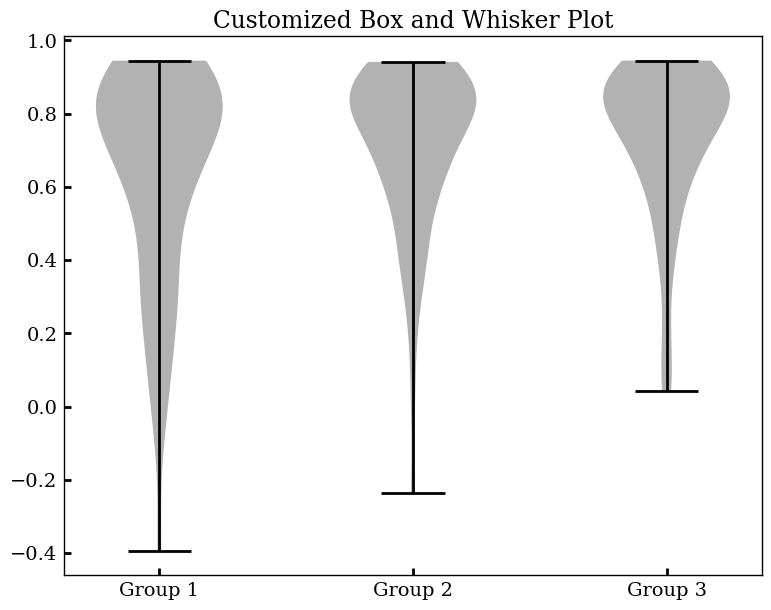

In [347]:
import matplotlib.pyplot as plt
import numpy as np

# Create some example data
data = outs # [np.random.normal(0, 1, 100), np.random.normal(0, 2, 100), np.random.normal(0, 0.5, 100)]

# Create an axis
fig, ax = plt.subplots()

# Customize the boxplot
boxplot = ax.violinplot(data, positions = box_x_positions)

# Adjust x-location (positions) and color of the boxes
box_x_positions = [1, 2, 3]  # Adjust the x-positions as needed
box_colors = ['red', 'green', 'blue']  # Adjust colors as needed

# Add labels to the y-axis
plt.xticks([1, 2, 3], ['Group 1', 'Group 2', 'Group 3'])

# Add a title
plt.title('Customized Box and Whisker Plot')

# Show the plot
plt.show()


65

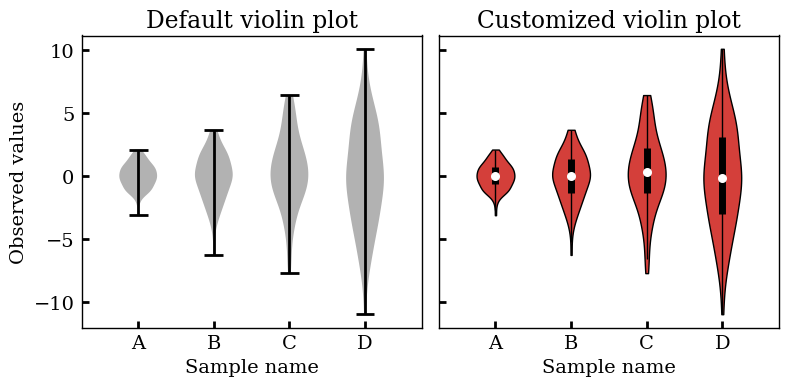

In [317]:
import matplotlib.pyplot as plt
import numpy as np


def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')


# create test data
np.random.seed(19680801)
data = [sorted(np.random.normal(0, std, 100)) for std in range(1, 5)]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), sharey=True)

ax1.set_title('Default violin plot')
ax1.set_ylabel('Observed values')
ax1.violinplot(data)

ax2.set_title('Customized violin plot')
parts = ax2.violinplot(
        data, showmeans=False, showmedians=False,
        showextrema=False)

for pc in parts['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax2.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax2.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

# set style for the axes
labels = ['A', 'B', 'C', 'D']
for ax in [ax1, ax2]:
    set_axis_style(ax, labels)

plt.subplots_adjust(bottom=0.15, wspace=0.05)
plt.show()

TypeError: Axes.boxplot() got an unexpected keyword argument 'label'

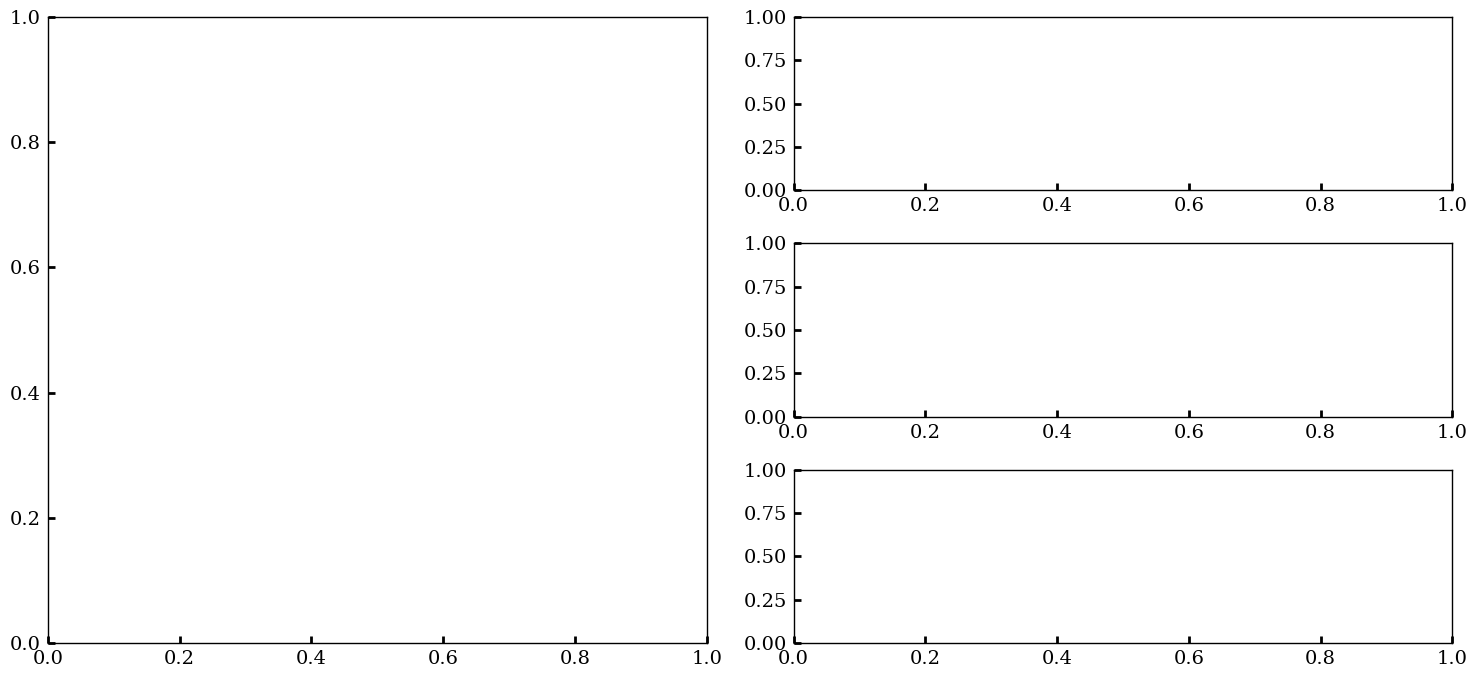

In [305]:
plt.rcParams['xtick.major.size'] = 5 
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.top'] = False  
plt.rcParams['ytick.right'] = False 
# datagrps = [[0],[1],[2],[3],[4]]
datagrps = [[0,1],[2,3],[4]]
labels = ['SNOTEL', 'Gridded', 'Intensive']

mosaic = """
    AB
    AC
    AD
    """
letters = ['B','C','D']
fig = plt.figure(figsize = (15,7), layout="tight")
ax_dict = fig.subplot_mosaic(mosaic)
ax = ax_dict['A']
for model in models:
    tmp_model = []
    for i in range(ng):
        tmp = []
        idxs = datagrps[i]
        for idx in idxs:
            mydata = np.array([tmp.values for tmp in outdatas[datas[idx]][model][:]])
            tmp.append(mydata)
        tmp_model.append(tmp)
    ax.boxplot(labels, tmp_model) #, label = model, linestyle = styles_model[model], color = colors_model[model])
ax.legend()
ax.set_ylim((-0.15,1.1))
ax.set_xlabel('Input Data')
ax.set_ylabel(r'R$^{2}$')
ax.legend()
for i, idxs in enumerate(datagrps):
    value = [datas[idx] for idx in idxs] 
    ax = ax_dict[letters[i]]
    idxs = datagrps[i]
    for model in models:
        ax.plot(years, r2vals.sel(pred_combo = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value,  color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])
    ax.set_ylim((-0.15,1.1))
    ax.set_ylabel(r'R$^{2}$')
    ax.text(2095,0.94,labels[i], color = colors_data[value[-1]],ha = 'right')
ax.set_xlabel('Year')
plt.show()



In [302]:
test = np.array([tmp.values for tmp in outdatas[datas[idx]][model][:]])

In [298]:
np.array(test)

(65, 20)

[0.09750385640697061, 0.08563566651264808, 0.5741489330591881]

In [ ]:
datagrps = [[0],[1],[2],[3],[4]]
ng = len(datagrps)
plot_arr = np.zeros((ng,3))
for i in range(ng):
    idxs = datagrps[i]
    rf_data = np.nanmean(normed_lr_r2_arr[idxs,:,:][normed_lr_r2_arr[idxs,:,:] > -5])
    lr_data = np.nanmean(normed_rf_r2_arr[idxs,:,:][normed_rf_r2_arr[idxs,:,:] > -5])
    plot_arr[i] = [lr_data, rf_data, np.nan]
fig,ax = plt.subplots(figsize=(5,5))
ax.pcolormesh(plot_arr, cmap = 'Blues', vmin = 0, vmax = 1)
ax.set_xticks([0.5,1.5,2.5], ['LR', 'RF', 'U-Net'])
ax.set_yticks([0.5,1.5,2.5,3.5,4.5][:ng], ['grp1', 'grp2','grp3','grp4','grp5'][:ng])
plt.show()

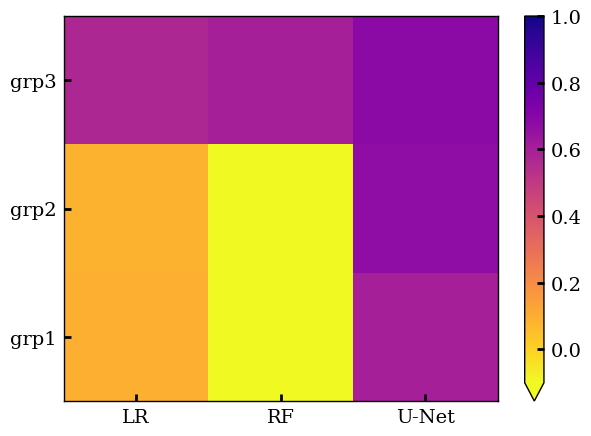

In [10]:
datagrps = [[0],[1],[2],[3],[4]]
datagrps = [[0,1],[2,3],[4]]

ng = len(datagrps)
plot_arr = np.zeros((ng,len(models)))
for i in range(ng):
    for j,model in enumerate(models):
        idxs = datagrps[i]
        tmp = []
        for idx in idxs:
            mydata = outdatas[datas[i]][model][:]
            tmp.append(mydata)
        plot_arr[i,j]=np.nanmean(tmp)

    #rf_data = np.nanmean(normed_lr_r2_arr[idxs,:,:][normed_lr_r2_arr[idxs,:,:] > -5])
    #lr_data = np.nanmean(normed_rf_r2_arr[idxs,:,:][normed_rf_r2_arr[idxs,:,:] > -5])
    #plot_arr[i] = [lr_data, rf_data, np.nan]
fig,ax = plt.subplots(figsize=(7,5))
cbar = ax.pcolormesh(plot_arr, cmap = 'plasma_r', vmin = -0.1, vmax = 1)
plt.colorbar(cbar, extend = 'min')
ax.set_xticks([0.5,1.5,2.5], ['LR', 'RF', 'U-Net'])
ax.set_yticks([0.5,1.5,2.5,3.5,4.5][:ng], ['grp1', 'grp2','grp3','grp4','grp5'][:ng])
plt.show()


In [130]:
years

array([2001, 2006, 2011, 2016, 2021, 2026, 2031, 2036, 2041, 2046, 2051,
       2056, 2061, 2066, 2071, 2076, 2081, 2086, 2091, 2096])

In [148]:
test = r2vals.sel(model = 'Unet').sel(pred_combo = 'Data_1').sel(test_year = 2016).sel(gcm = 'canesm5_r1i1p2f1_ssp370')

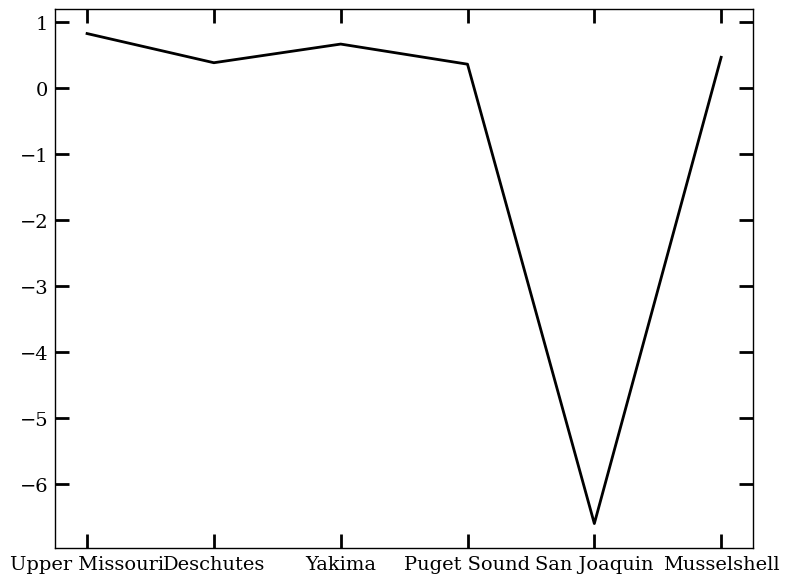

In [151]:
plt.plot(test.basin[22:28], test.value[22:28])

In [4]:
sweMax = xr.open_dataset('snowMax.nc').compute().rename({'__xarray_dataarray_variable__': 'swe'})
datas = err['pred_combo'].values
test_years = err['test_year'].values
norms = []
for year in err['test_year'].values:
    val= sweMax.sel(year = year).mean()['swe'].values.flatten()[0]
    norms.append(val)
    
mydata = err.sel(metric = 'rmse').sum(dim = 'gcm')
lr = mydata.sel(model = 'linreg')
rf = mydata.sel(model = 'RF')
normed_rf_rmse = []
normed_lr_rmse = []

for data in datas:
    tmp = rf.sel(pred_combo =data)
    normed_rf_rmse.append(tmp['value'].values / norms)
    tmp = lr.sel(pred_combo =data)
    normed_lr_rmse.append(tmp['value'].values / norms)

normed_rf_rmse_arr = np.array(normed_rf_rmse)
normed_lr_rmse_arr = np.array(normed_lr_rmse)

normed_lr_rmse_arr[:,49:51] = np.nan
normed_rf_rmse_arr[:,49:51] = np.nan

In [5]:
mydata = err.sel(metric = 'r2').mean(dim = 'gcm')
lr = mydata.sel(model = 'linreg')
rf = mydata.sel(model = 'RF')
normed_rf_r2 = []
normed_lr_r2 = []

for data in datas:
    tmp = rf.sel(pred_combo =data)
    normed_rf_r2.append(tmp['value'].values)
    tmp = lr.sel(pred_combo =data)
    normed_lr_r2.append(tmp['value'].values)

normed_rf_r2_arr = np.array(normed_rf_r2)
normed_lr_r2_arr = np.array(normed_lr_r2)

normed_lr_r2_arr[:,49:51] = np.nan
normed_rf_r2_arr[:,49:51] = np.nan

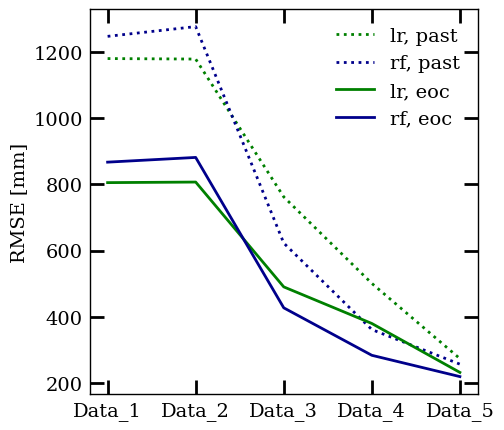

In [6]:

fig,ax = plt.subplots(1,1, figsize =(5,5))
mydata = err.sel(metric = 'rmse').median(dim = 'basin').sum(dim = 'gcm')
lr = mydata.sel(model = 'linreg')
rf = mydata.sel(model = 'RF')
ax.plot(datas, lr['value'][0:10,:].mean(dim = 'test_year').data, label = 'lr, past', color = colors_model['lr'], linestyle = ':')
ax.plot(datas, rf['value'][0:10,:].mean(dim = 'test_year').data, label = 'rf, past', color = colors_model['rf'], linestyle = ':')
ax.plot(datas, lr['value'][-10:,:].mean(dim = 'test_year').data,  label = 'lr, eoc',color = colors_model['lr'])
ax.plot(datas, rf['value'][-10:,:].mean(dim = 'test_year').data,  label = 'rf, eoc',color = colors_model['rf'])
ax.set_ylabel('RMSE [mm]')
ax.legend()
plt.show()

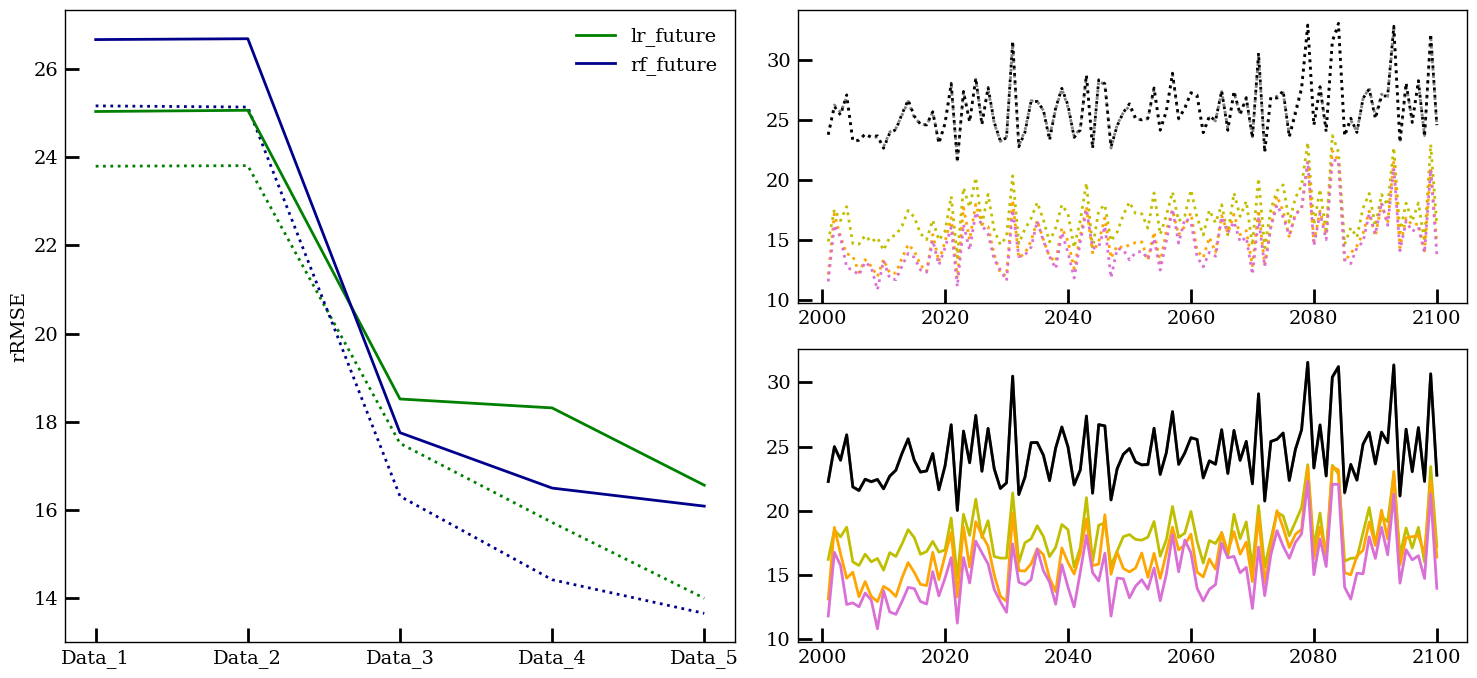

In [113]:
mosaic = """
    AB
    AC
    """

fig = plt.figure(figsize = (15,7), layout="tight")
ax_dict = fig.subplot_mosaic(mosaic)
ax = ax_dict['A']
ax.plot(datas, np.nanmean(normed_lr_rmse_arr[:,:,0:5],axis =(1,2)), color = colors_model['lr'], linestyle = ':')
ax.plot(datas,np.nanmean(normed_rf_rmse_arr[:,:,0:5],axis =(1,2)), color = colors_model['rf'], linestyle = ':')
ax.plot(datas,np.nanmean(normed_lr_rmse_arr[:,:,-5:],axis =(1,2)),color = colors_model['lr'], label = 'lr_future')
ax.plot(datas, np.nanmean(normed_rf_rmse_arr[:,:,-5:],axis =(1,2)), color = colors_model['rf'], label = 'rf_future')
ax.set_ylabel('rRMSE [mm/mm]')
ax.legend()
for i, value in enumerate(datas):
    ax_dict['B'].plot(test_years,(np.nanmean(normed_rf_rmse_arr[i,:,:],axis=0)), color = colors_data[value], label =  value, linestyle = ':')
    ax_dict['C'].plot(test_years,(np.nanmean(normed_lr_rmse_arr[i,:,:],axis=0)), color = colors_data[value], label = value)
    ax.set_ylabel('rRMSE')
ax.legend(bbox_to_anchor= [1,0,0,1])
plt.show()


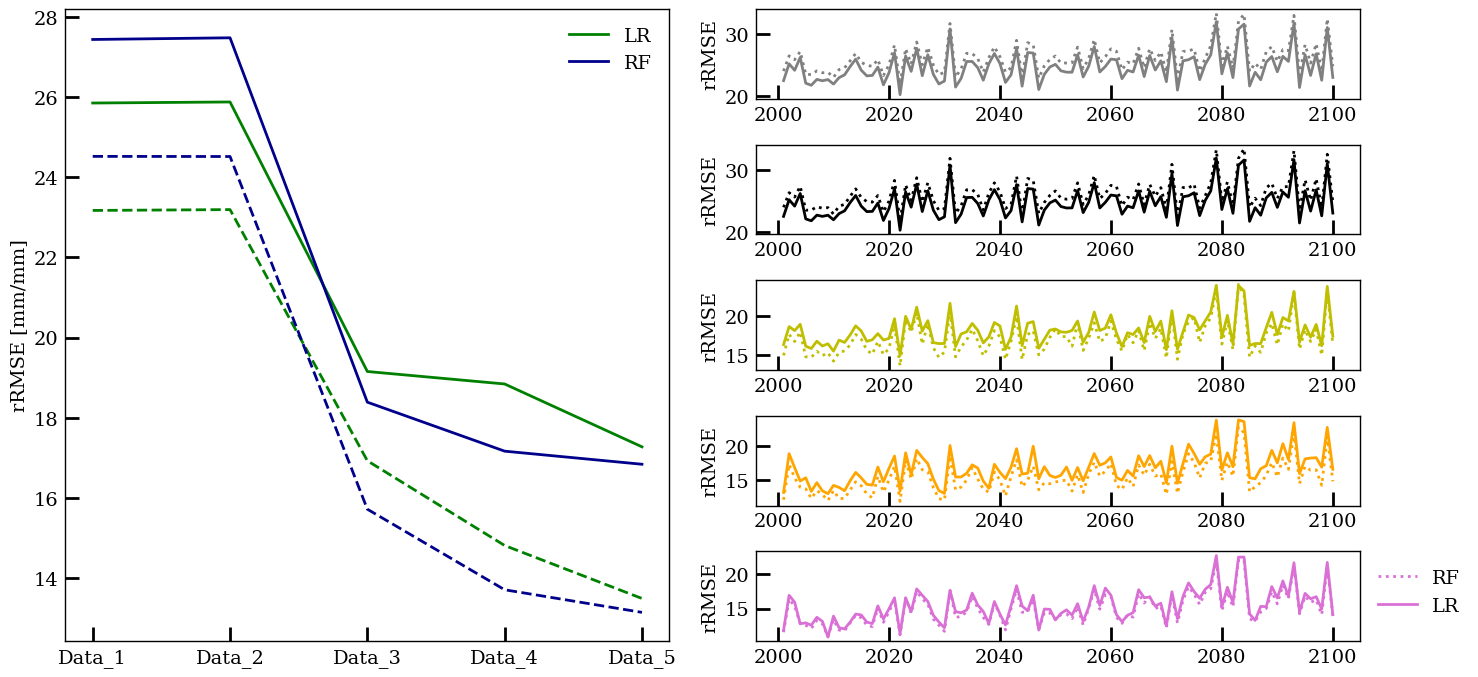

In [114]:
mosaic = """
    AB
    AC
    AD
    AE
    AF
    """
normed_lr_rmse_arr[:,49] = np.nan
normed_rf_rmse_arr[:,49] = np.nan
letters = ['B','C','D','E','F']
fig = plt.figure(figsize = (15,7), layout="tight")
ax_dict = fig.subplot_mosaic(mosaic)
ax = ax_dict['A']
ax.plot(datas, np.nanmean(normed_lr_rmse_arr[:,:,0:10],axis =(1,2)), color = colors_model['lr'], marker = '', linestyle = '--')
ax.plot(datas,np.nanmean(normed_rf_rmse_arr[:,:,0:10],axis  =(1,2)), color = colors_model['rf'], marker = '', linestyle = '--')
ax.plot(datas,np.nanmean(normed_lr_rmse_arr[:,:,-10:],axis =(1,2)),color = colors_model['lr'], label = 'LR')
ax.plot(datas, np.nanmean(normed_rf_rmse_arr[:,:,-10:],axis  =(1,2)), color = colors_model['rf'], label = 'RF')
ax.set_ylabel('rRMSE [mm/mm]')
ax.legend()
for i, value in enumerate(datas):
    ax = ax_dict[letters[i]]
    ax.plot(test_years,(np.nanmean(normed_rf_rmse_arr[i,:,:],axis=0)),  color = colors_data[value], label =  'RF', linestyle = ':')
    ax.plot(test_years,(np.nanmean(normed_lr_rmse_arr[i,:,:],axis=0)), colors_data[value], label = 'LR')
    ax.set_ylabel('rRMSE')
ax.legend(bbox_to_anchor= [1,0,0,1])

plt.show()

ValueError: X must have 2 or fewer dimensions

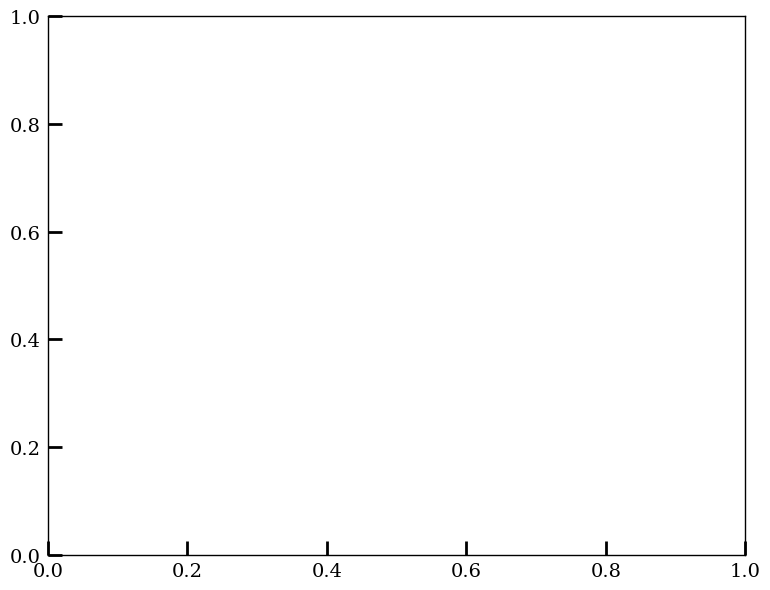

In [115]:

data_to_plot = normed_lr_rmse_arr
fig, ax = plt.subplots()
ax.boxplot(data_to_plot, labels=['LR', 'RF'], whis='range', showfliers=False, patch_artist=True)

ax.set_ylabel('rRMSE [mm/mm]')
ax.set_xlabel('Models')
ax.set_title('Box and Whisker Plots of rRMSE')

# You can customize the appearance of the boxes and whiskers using 'patch_artist' and 'boxprops'.
for box in ax.artists:
    box.set_facecolor('lightblue')
    
plt.show()


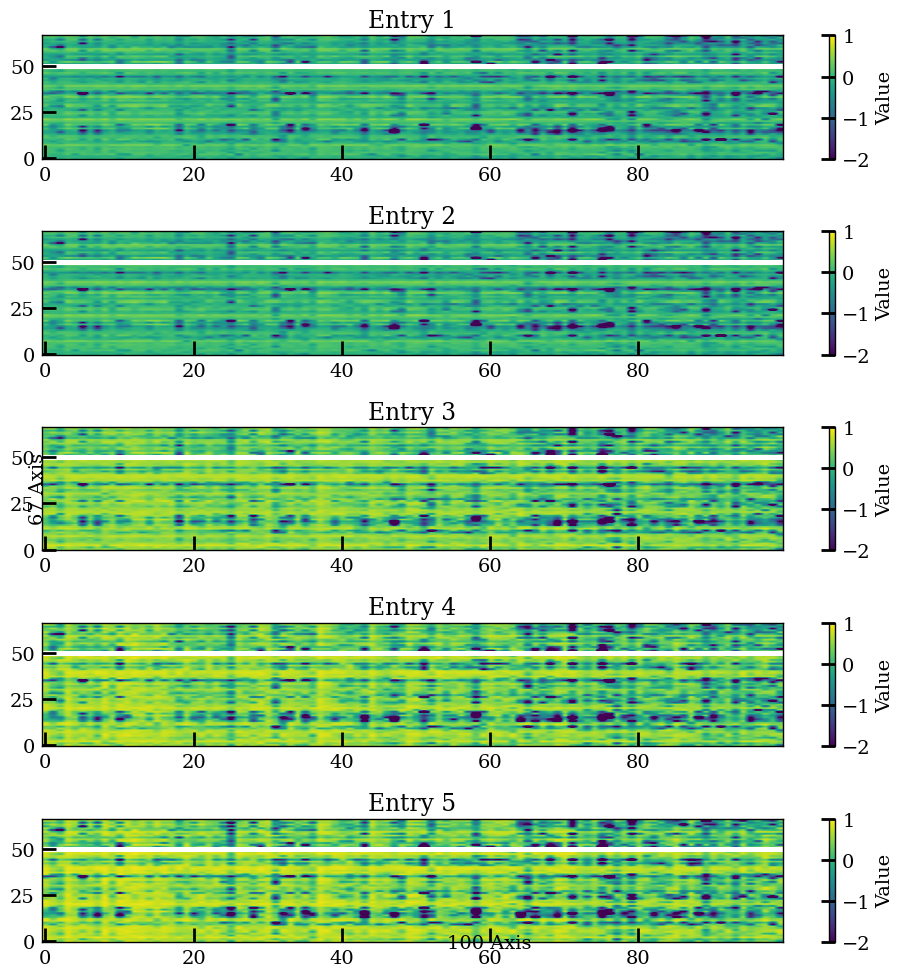

In [126]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have your data in a NumPy array of shape (5, 67, 100)
data = normed_lr_r2_arr  # Replace this with your actual data

# Create subplots with one row and five columns
fig, axs = plt.subplots(5, 1, figsize=(10, 10))

# Iterate through the five entries and create a plot for each
for i in range(5):
    ax = axs[i]
    entry_data = data[i, :, :]  # Extract the data for the current entry
    
    # Create a heatmap of the data on the 67 and 100 axes
    im = ax.imshow(entry_data, cmap='viridis', origin='lower', aspect='auto', vmin = -2, vmax = 1)
    ax.set_title(f'Entry {i + 1}')
    
    # Add colorbar for reference
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Value')
    
# Add a common y-axis label
fig.text(0.04, 0.5, '67 Axis', va='center', rotation='vertical')

# Add a common x-axis label
fig.text(0.5, 0.04, '100 Axis', ha='center')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


/tmp/ipykernel_998757/2186137484.py:1: RuntimeWarning: Mean of empty slice
  find_bad_basins = np.nanmean(normed_lr_r2_arr, axis = 0)


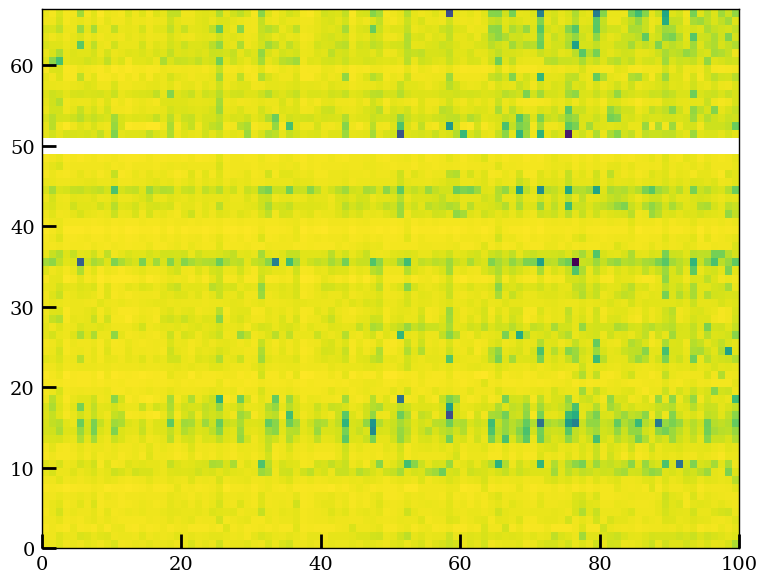

In [123]:
find_bad_basins = np.nanmean(normed_lr_r2_arr, axis = 0)
plt.pcolormesh(find_bad_basins[:,:])
#plt.pcolormesh(find_bad_basins[49:50,:])

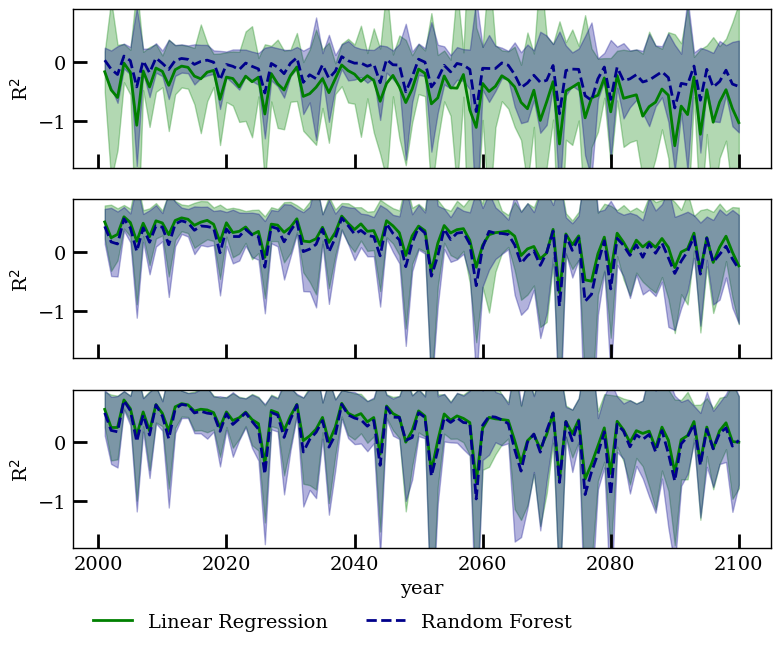

In [124]:
fig,axs = plt.subplots(3,1)


datagrps = [[0,1],[2,3],[4]]
names = ['SNOTEL', 'meteorology', 'intensive']
for i in range(3):
    ax = axs[i]
    idxs = datagrps[i]
    rf_data = np.nanmean(normed_lr_r2_arr[idxs,:,:], axis = (0,1))
    rf_sd = np.nanstd(normed_lr_r2_arr[idxs,:,:], axis = (0,1))
    lr_data = np.nanmean(normed_rf_r2_arr[idxs,:,:], axis = (0,1))
    lr_sd = np.nanstd(normed_rf_r2_arr[idxs,:,:], axis = (0,1))
    ax.plot(test_years, lr_data, label = 'Linear Regression', linestyle = '-', color = colors_model['lr'])
    ax.plot(test_years, rf_data, label = 'Random Forest', linestyle = '--', color = colors_model['rf'])
    ax.fill_between(test_years, lr_data + lr_sd, lr_data - lr_sd, alpha = 0.3, color = colors_model['lr'])
    ax.fill_between(test_years, rf_data + rf_sd, rf_data - rf_sd, alpha = 0.3, color = colors_model['rf'])

    ax.set_ylabel(r'R$^2$')
    ax.set_ylim((-1.8,0.9))
    if i < 2: ax.set_xticklabels([])
ax.set_xlabel('year')
ax.legend(bbox_to_anchor= [0.74,-0.3,0,0], ncol = 2)
plt.show()


{'lr': 'darkblue', 'rf': 'red'}

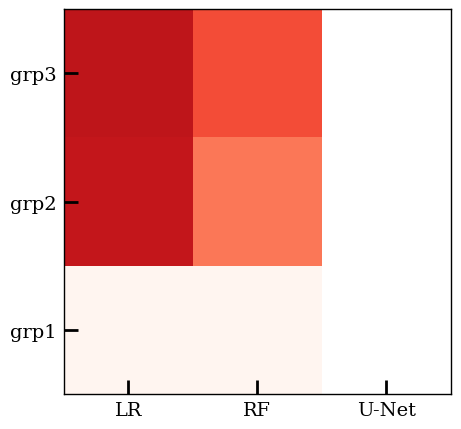

In [125]:
datagrps = [[0,1],[2,3],[4]]
plot_arr = np.zeros((3,3))
for i in range(3):
    idxs = datagrps[i]
    rf_data = np.nanmean(normed_lr_r2_arr[idxs,:,:], axis = (0,1))
    lr_data = np.nanmean(normed_rf_r2_arr[idxs,:,:], axis = (0,1))
    plot_arr[i] = [np.nanmean(lr_data), np.nanmean(rf_data), np.nan]
fig,ax = plt.subplots(figsize=(5,5))
ax.pcolormesh(plot_arr, cmap = 'Reds', vmin = 0, vmax = 0.3)
ax.set_xticks([0.5,1.5,2.5], ['LR', 'RF', 'U-Net'])
ax.set_yticks([0.5,1.5,2.5], ['grp1', 'grp2','grp3'])
plt.show()


In [120]:
normed_lr_r2_arr.shape

(5, 67, 100)

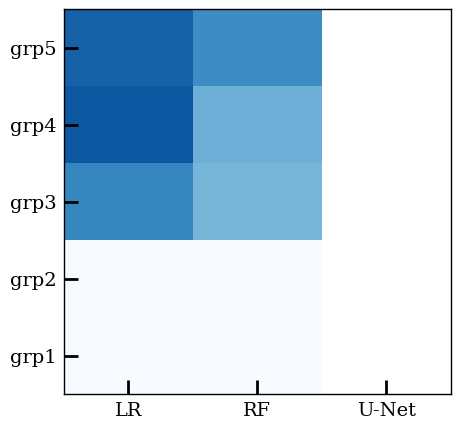

In [38]:
datagrps = [[0],[1],[2],[3],[4]]
ng = len(datagrps)
plot_arr = np.zeros((ng,3))
for i in range(ng):
    idxs = datagrps[i]
    rf_data = np.nanmean(normed_lr_r2_arr[idxs,:,:][normed_lr_r2_arr[idxs,:,:] > -5])
    lr_data = np.nanmean(normed_rf_r2_arr[idxs,:,:][normed_rf_r2_arr[idxs,:,:] > -5])
    plot_arr[i] = [lr_data, rf_data, np.nan]
fig,ax = plt.subplots(figsize=(5,5))
ax.pcolormesh(plot_arr, cmap = 'Blues', vmin = 0, vmax = 0.3)
ax.set_xticks([0.5,1.5,2.5], ['LR', 'RF', 'U-Net'])
ax.set_yticks([0.5,1.5,2.5,3.5,4.5][:ng], ['grp1', 'grp2','grp3','grp4','grp5'][:ng])
plt.show()


In [33]:
normed_lr_r2_arr.shape

(5, 67, 100)

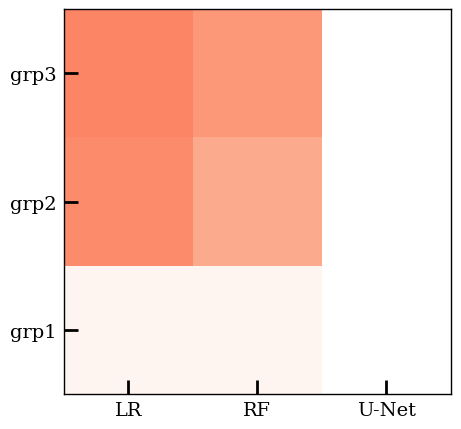

In [40]:
datagrps = [[0,1],[2,3],[4]]
plot_arr = np.zeros((3,3))
for i in range(3):
    idxs = datagrps[i]
    rf_data = np.nanmean(normed_lr_r2_arr[idxs,:,:20], axis = (0,1))
    lr_data = np.nanmean(normed_rf_r2_arr[idxs,:,:20], axis = (0,1))
    plot_arr[i] = [np.nanmean(lr_data), np.nanmean(rf_data), np.nan]
fig,ax = plt.subplots(figsize=(5,5))
ax.pcolormesh(plot_arr, cmap = 'Reds', vmin = 0, vmax = 1)
ax.set_xticks([0.5,1.5,2.5], ['LR', 'RF', 'U-Net'])
ax.set_yticks([0.5,1.5,2.5], ['grp1', 'grp2','grp3'])
plt.show()

In [1]:
lrcolor = 'skyblue'
rfcolor = 'darkgreen'
fig,axs = plt.subplots(3,1)
datagrps = [[0,1],[2,3],[4]]
names = ['SNOTEL', 'meteorology', 'intensive']
for i in range(3):
    ax = axs[i]
    idxs = datagrps[i]
    rf_data = np.nanmean(normed_lr_r2_arr[idxs,:], axis = (0,1))
    rf_sd = np.nanstd(normed_lr_r2_arr[idxs,:], axis =  (0,1))
    lr_data = np.nanmean(normed_rf_r2_arr[idxs,:], axis = (0,1))
    lr_sd = np.nanstd(normed_rf_r2_arr[idxs,:], axis  = (0,1))
    
    ax.plot(test_years, lr_data, label = 'Linear Regression', linestyle = '-', color = lrcolor)
    ax.plot(test_years, rf_data, label = 'Random Forest', linestyle = '--', color = rfcolor)
    
    #ax.fill_between(test_years, lr_data + lr_sd, lr_data - lr_sd, alpha = 0.3, color = lrcolor)
    #ax.fill_between(test_years, rf_data + rf_sd, lr_data - lr_sd, alpha = 0.3, color = rfcolor)

    ax.set_ylabel(r'R2')
ax.legend(bbox_to_anchor= [0.85,-0.1,0,0], ncol = 2)
plt.show()


NameError: name 'plt' is not defined

In [ ]:
## are the worse years correlated to less snow?

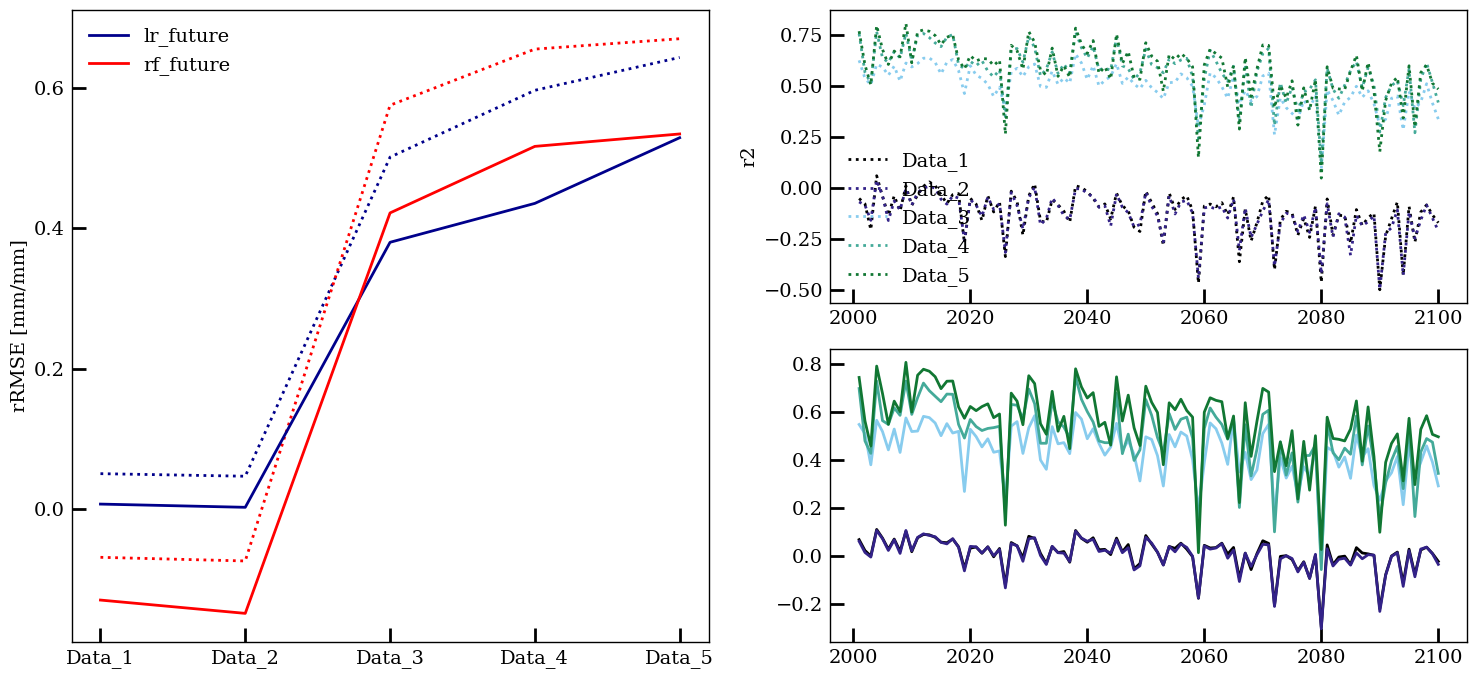

In [25]:
mosaic = """
    AB
    AC
    """

letters = ['B','C']
fig = plt.figure(figsize = (15,7), layout="tight")
ax_dict = fig.subplot_mosaic(mosaic)
ax = ax_dict['A']
ax.plot(datas, np.nanmean(normed_lr_r2_arr[:,0:10],axis =1), color = colors['lr'], linestyle = ':')
ax.plot(datas,np.nanmean(normed_rf_r2_arr[:,0:10],axis =1), color = colors['rf'], linestyle = ':')
ax.plot(datas,np.nanmean(normed_lr_r2_arr[:,-3:],axis =1),color = colors['lr'], label = 'lr_future')
ax.plot(datas, np.nanmean(normed_rf_r2_arr[:,-3:],axis =1), color = colors['rf'], label = 'rf_future')
ax.set_ylabel('rRMSE [mm/mm]')
ax.legend()
for i, value in enumerate(datas):
    ax = ax_dict['B']
    ax_dict['B'].plot(test_years,(normed_rf_r2_arr[i,:]), label =  value, linestyle = ':')
    ax_dict['C'].plot(test_years,(normed_lr_r2_arr[i,:]), label = 'lr')
    ax.set_ylabel('r2')
ax.legend()

plt.show()